In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.holtwinters import Holt

get_ipython().run_line_magic('matplotlib', 'inline')
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
df = pd.read_csv(r'C:\Users\User\Desktop\DATA SCIENCE\Kaggle Projects\Daily Delhi climate\DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


### Converting datetype of date into datetime

In [4]:
df['date'] = pd.DatetimeIndex(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
 5   year          1462 non-null   int64         
 6   month         1462 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 80.1 KB


In [6]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure,year,month
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1


### Setting date as index 

In [7]:
#Setting date as index
df = df.set_index('date')
df.head()

,meantemp,humidity,wind_speed,meanpressure,year,month
date,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1


In [63]:
df.tail()

,meantemp,humidity,wind_speed,meanpressure,year,month
date,,,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016,12
2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016,12
2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016,12
2016-12-31,15.052632,87.000000,7.325000,1016.100000,2016,12
2017-01-01,10.000000,100.000000,0.000000,1016.000000,2017,1


### Checking if any null value exists 

In [8]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
year            0
month           0
dtype: int64

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333
year,1462.0,2014.502736,1.120248,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000
month,1462.0,6.519152,3.451727,1.000000,4.000000,7.000000,10.000000,12.000000


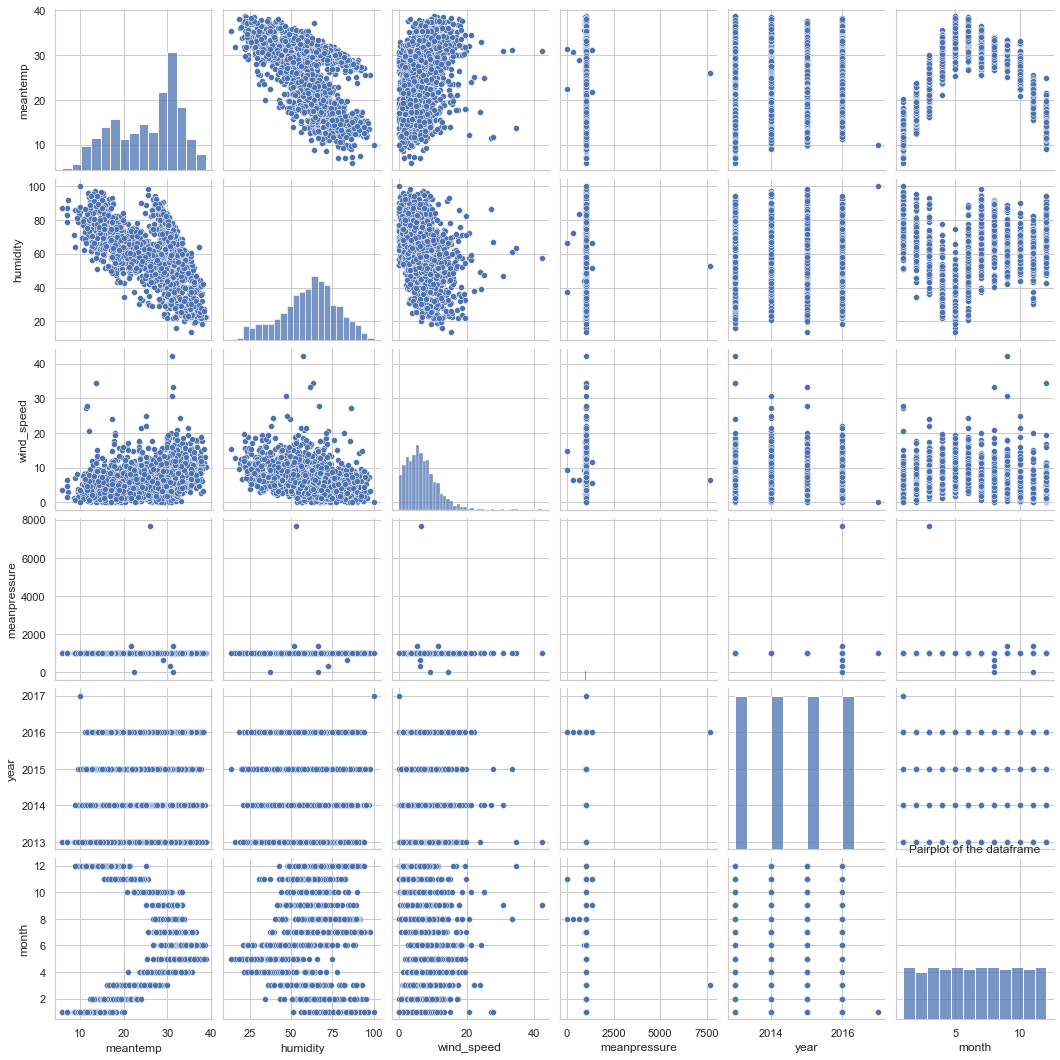

In [10]:
sns.pairplot(df)
plt.title('Pairplot of the dataframe')
plt.show()

### Decomposition of Time Series 

* Any time series distribution has 3 core components:

* Seasonality - does the data have a clear cyclical/periodic pattern?
* Trend - does the data represent a general upward or downward slope?
* Noise - what are the outliers or missing values that are not consistent with the rest of the data?

* Deconstructing a time series into these components is called decomposition, and we will explore each one in detail.



### meantemp 

In [11]:
df.meantemp.describe()

count    1462.000000
mean       25.495521
std         7.348103
min         6.000000
25%        18.857143
50%        27.714286
75%        31.305804
max        38.714286
Name: meantemp, dtype: float64

In [12]:
df.meantemp.value_counts()

31.000000    18
30.000000    15
32.125000    15
28.500000    14
30.750000    14
             ..
18.133333     1
22.826087     1
34.733333     1
37.214286     1
9.250000      1
Name: meantemp, Length: 617, dtype: int64

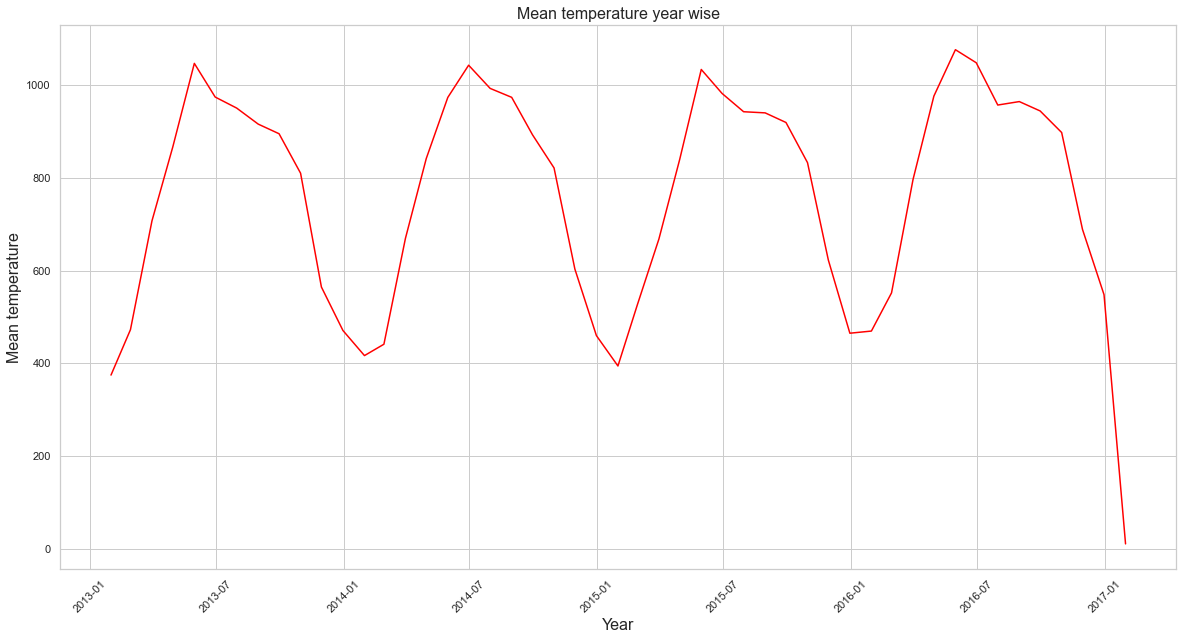

In [13]:
plt.figure(figsize=(20,10))
plt.plot(df.meantemp.resample('M').sum(), color="red")
plt.xticks(rotation=45)
plt.title('Mean temperature year wise',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Mean temperature',fontsize=16)
plt.show()

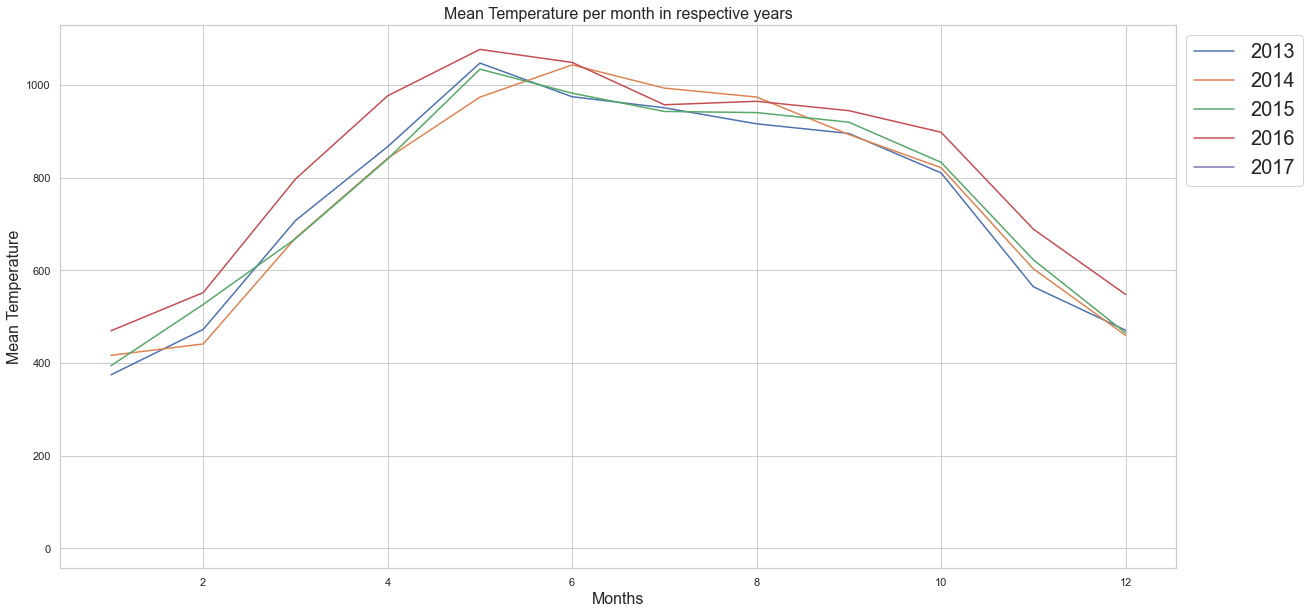

In [14]:
#Plot Mean temperature Monthly wise in respective years
plt.figure(figsize=(20,10))
plt.plot(df[df.year==2013].groupby('month')['meantemp'].sum())
plt.plot(df[df.year==2014].groupby('month')['meantemp'].sum())
plt.plot(df[df.year==2015].groupby('month')['meantemp'].sum())
plt.plot(df[df.year==2016].groupby('month')['meantemp'].sum())
plt.plot(df[df.year==2017].groupby('month')['meantemp'].sum())
plt.xlabel('Months',fontsize=16)
plt.ylabel('Mean Temperature',fontsize=16)
plt.title('Mean Temperature per month in respective years',fontsize=16)
plt.legend([2013,2014,2015,2016,2017],bbox_to_anchor=(1, 1), loc=2,prop={"size":20})
plt.show()

### humidity 

In [15]:
df.humidity.describe()

count    1462.000000
mean       60.771702
std        16.769652
min        13.428571
25%        50.375000
50%        62.625000
75%        72.218750
max       100.000000
Name: humidity, dtype: float64

In [16]:
df.humidity.value_counts()

65.500000    9
65.750000    8
67.000000    7
63.875000    7
69.000000    7
            ..
59.714286    1
73.814815    1
50.875000    1
64.866667    1
58.571429    1
Name: humidity, Length: 897, dtype: int64

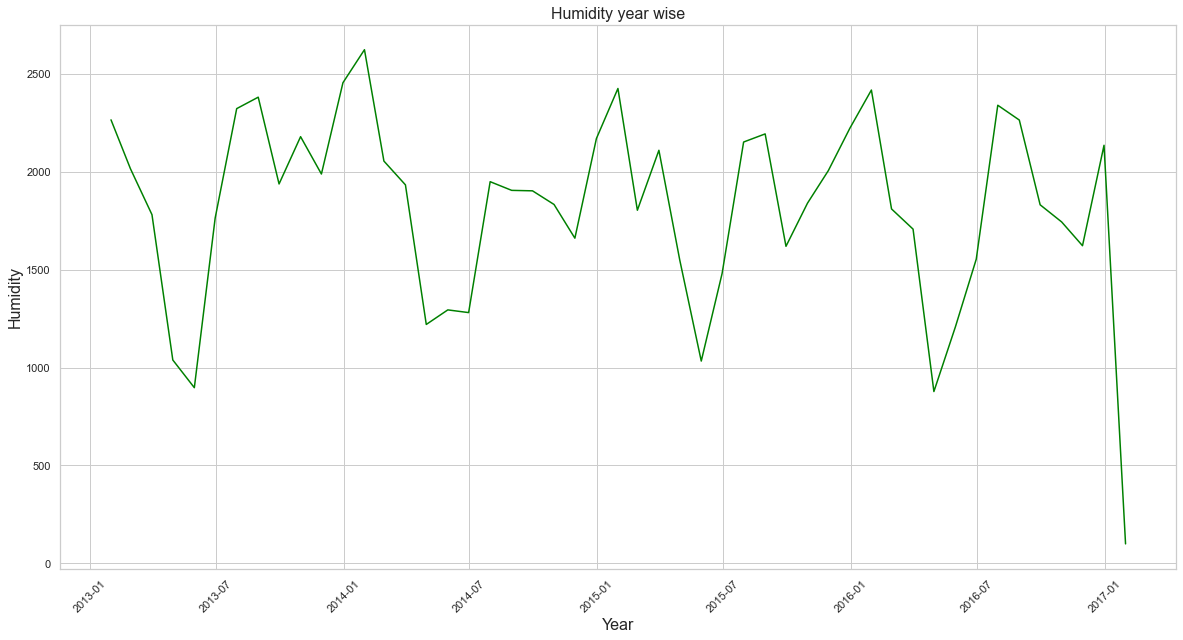

In [17]:
plt.figure(figsize=(20,10))
plt.plot(df.humidity.resample('M').sum(), color="green")
plt.xticks(rotation=45)
plt.title('Humidity year wise',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Humidity',fontsize=16)
plt.show()

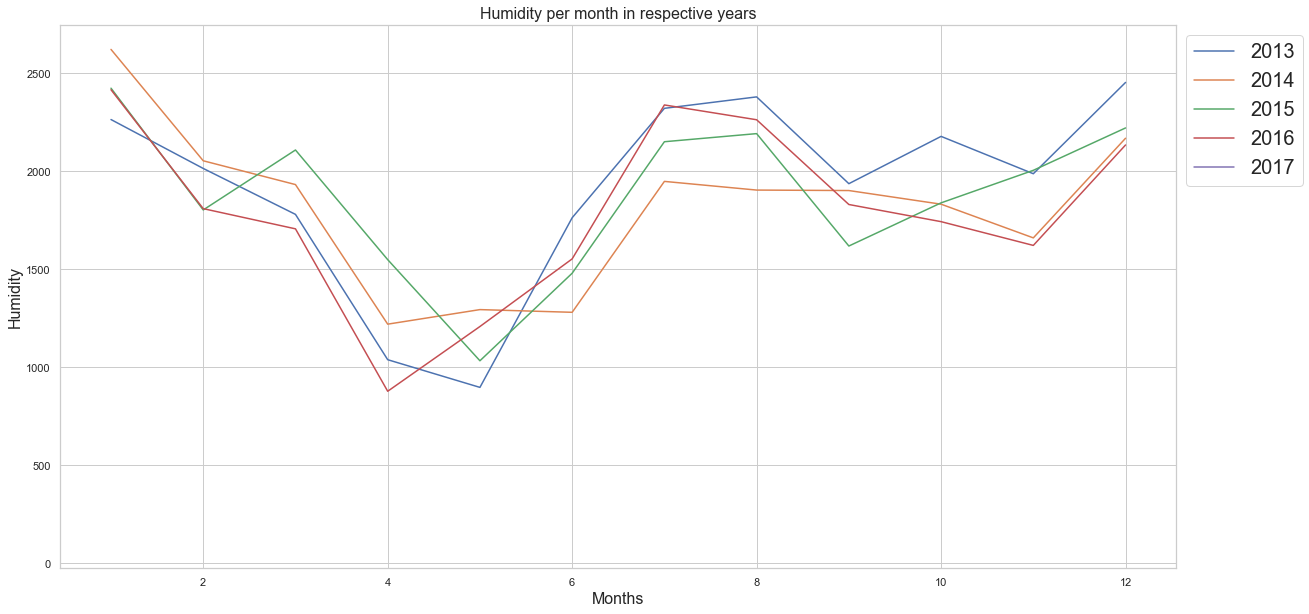

In [18]:
#Plot Humidity Monthly wise in respective years
plt.figure(figsize=(20,10))
plt.plot(df[df.year==2013].groupby('month')['humidity'].sum())
plt.plot(df[df.year==2014].groupby('month')['humidity'].sum())
plt.plot(df[df.year==2015].groupby('month')['humidity'].sum())
plt.plot(df[df.year==2016].groupby('month')['humidity'].sum())
plt.plot(df[df.year==2017].groupby('month')['humidity'].sum())
plt.xlabel('Months',fontsize=16)
plt.ylabel('Humidity',fontsize=16)
plt.title('Humidity per month in respective years',fontsize=16)
plt.legend([2013,2014,2015,2016,2017],bbox_to_anchor=(1, 1), loc=2,prop={"size":20})
plt.show()

### wind_speed 

In [19]:
df['wind_speed'].describe()

count    1462.000000
mean        6.802209
std         4.561602
min         0.000000
25%         3.475000
50%         6.221667
75%         9.238235
max        42.220000
Name: wind_speed, dtype: float64

In [20]:
df['wind_speed'].value_counts()

0.000000     26
0.925000     24
1.850000     20
1.162500     18
2.550000     18
             ..
6.553333      1
14.494118     1
5.787500      1
8.225000      1
12.966667     1
Name: wind_speed, Length: 730, dtype: int64

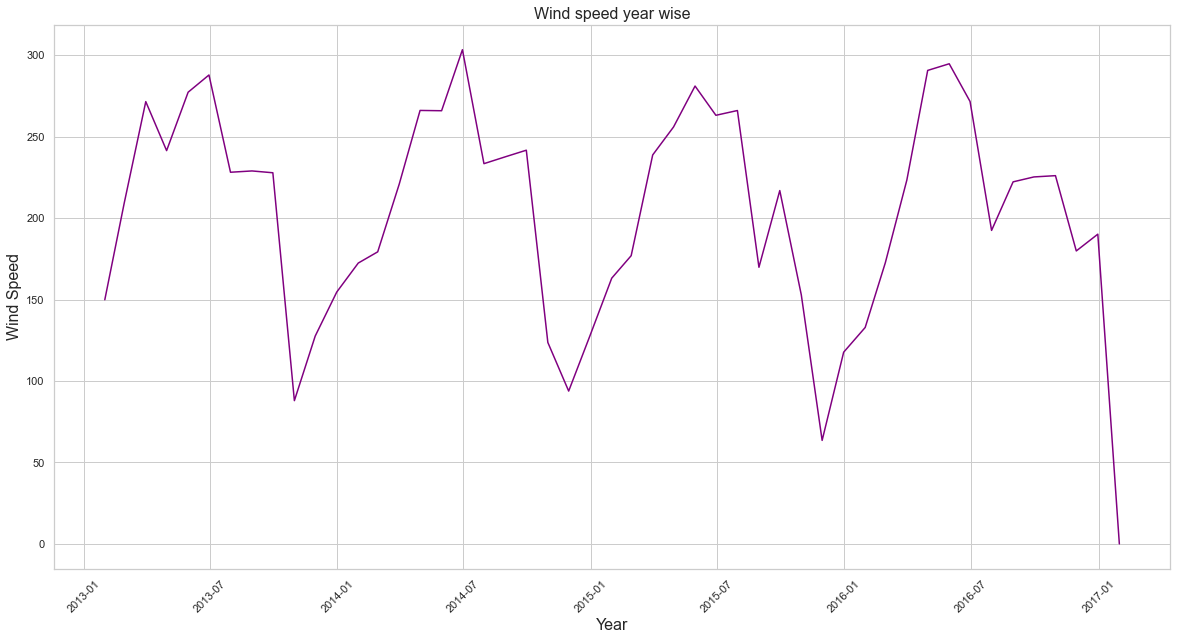

In [21]:
plt.figure(figsize=(20,10))
plt.plot(df.wind_speed.resample('M').sum(), color="purple") 
#Most commonly used time series frequency are –
#W : weekly frequency
#M : month end frequency
#SM : semi-month end frequency (15th and end of month)
#Q : quarter end frequency
plt.xticks(rotation=45)
plt.title('Wind speed year wise',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Wind Speed',fontsize=16)
plt.show()

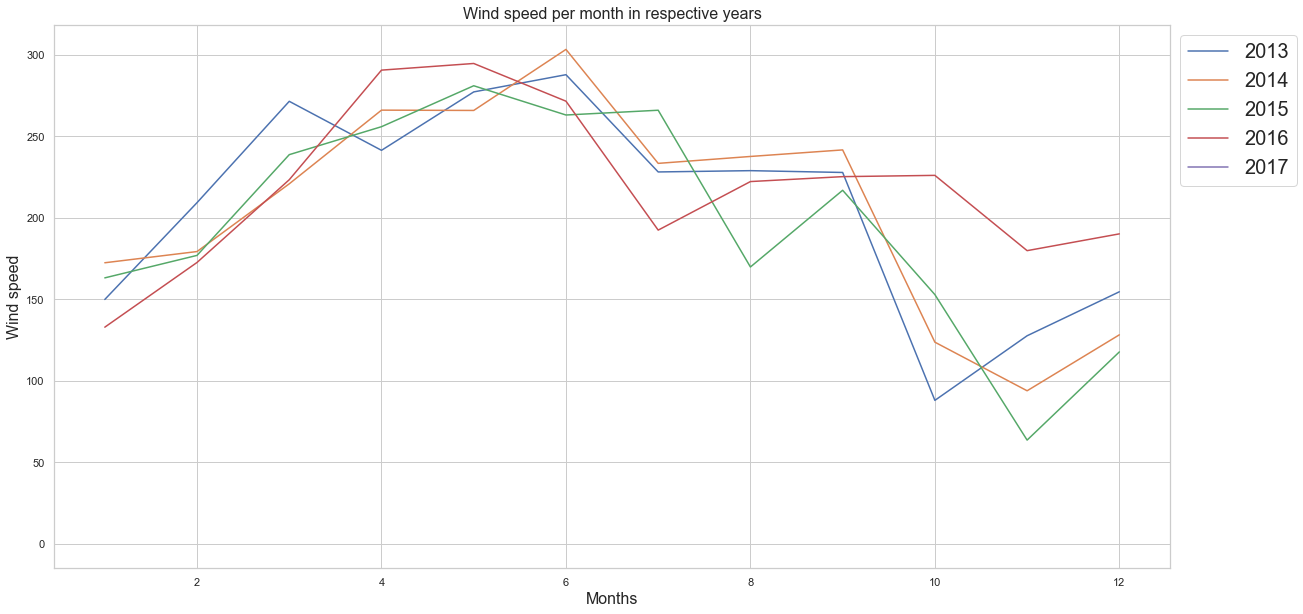

In [22]:
#Plot Windspeed Monthly wise in respective years
plt.figure(figsize=(20,10))
plt.plot(df[df.year==2013].groupby('month')['wind_speed'].sum())
plt.plot(df[df.year==2014].groupby('month')['wind_speed'].sum())
plt.plot(df[df.year==2015].groupby('month')['wind_speed'].sum())
plt.plot(df[df.year==2016].groupby('month')['wind_speed'].sum())
plt.plot(df[df.year==2017].groupby('month')['wind_speed'].sum())
plt.xlabel('Months',fontsize=16)
plt.ylabel('Wind speed',fontsize=16)
plt.title('Wind speed per month in respective years',fontsize=16)
plt.legend([2013,2014,2015,2016,2017],bbox_to_anchor=(1, 1), loc=2,prop={"size":20})
plt.show()

### meanpressure

In [23]:
df['meanpressure'].describe()

count    1462.000000
mean     1011.104548
std       180.231668
min        -3.041667
25%      1001.580357
50%      1008.563492
75%      1014.944901
max      7679.333333
Name: meanpressure, dtype: float64

In [24]:
df['meanpressure'].value_counts()

1016.000000    13
1017.000000    13
1007.000000    12
1003.250000    12
998.000000     12
               ..
1020.571429     1
1007.266667     1
994.000000      1
1001.272727     1
1000.160000     1
Name: meanpressure, Length: 626, dtype: int64

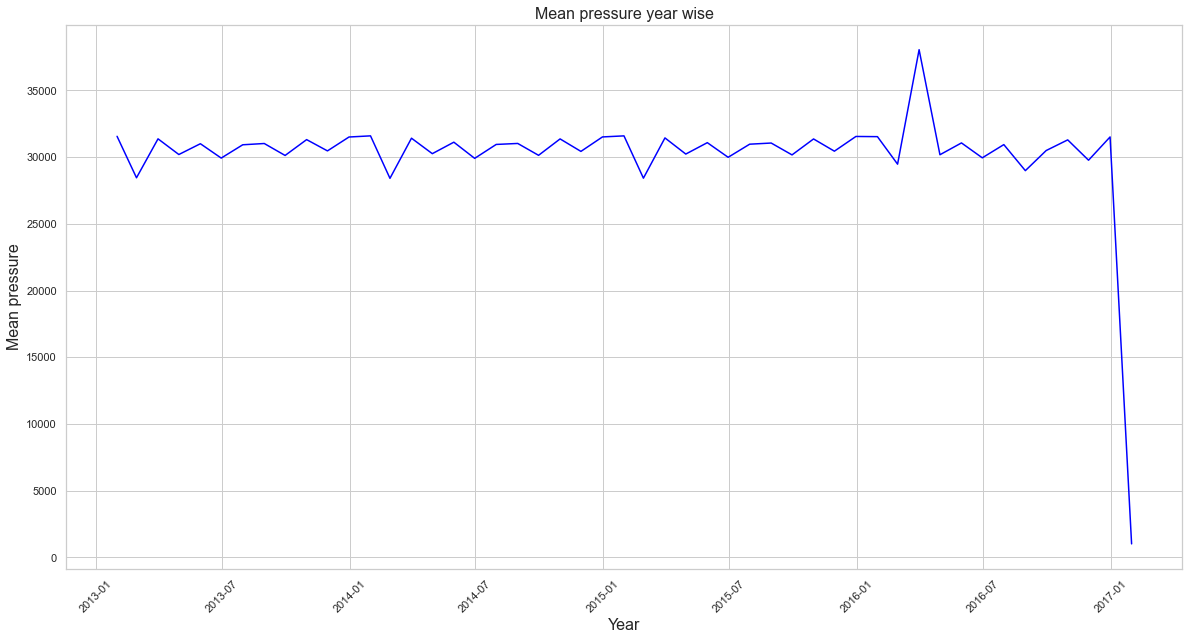

In [25]:
plt.figure(figsize=(20,10))
plt.plot(df.meanpressure.resample('M').sum(), color="blue")
plt.xticks(rotation=45)
plt.title('Mean pressure year wise',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Mean pressure',fontsize=16)
plt.show()

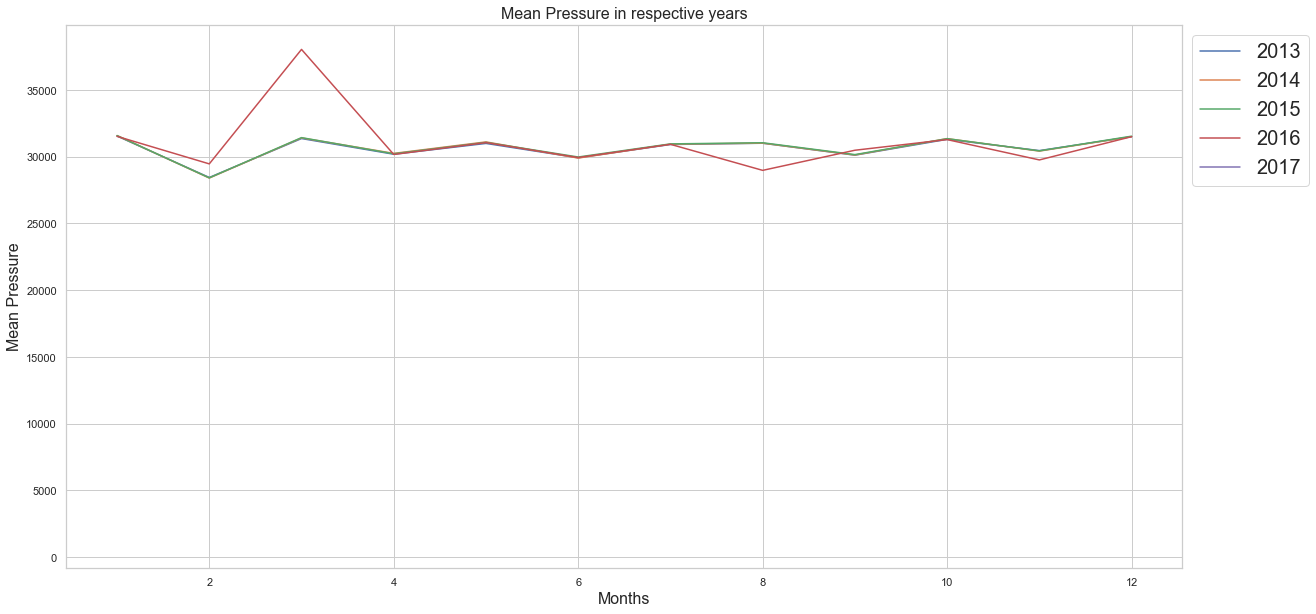

In [28]:
#Plot meanpressure Monthly wise in respective years
plt.figure(figsize=(20,10))
plt.plot(df[df.year==2013].groupby('month')['meanpressure'].sum())
plt.plot(df[df.year==2014].groupby('month')['meanpressure'].sum())
plt.plot(df[df.year==2015].groupby('month')['meanpressure'].sum())
plt.plot(df[df.year==2016].groupby('month')['meanpressure'].sum())
plt.plot(df[df.year==2017].groupby('month')['meanpressure'].sum())
plt.xlabel('Months',fontsize=16)
plt.ylabel('Mean Pressure',fontsize=16)
plt.title('Mean Pressure in respective years',fontsize=16)
plt.legend([2013,2014,2015,2016,2017],bbox_to_anchor=(1, 1), loc=2,prop={"size":20})
plt.show()

### ADDITIVE MODEL 

date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-05    0.0
             ... 
2016-12-28    0.0
2016-12-29    0.0
2016-12-30    0.0
2016-12-31    0.0
2017-01-01    0.0
Name: resid, Length: 1462, dtype: float64

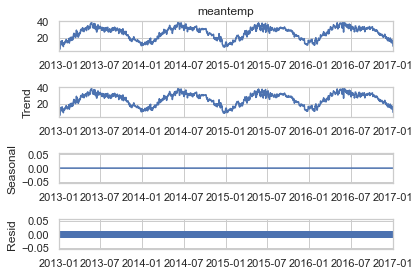

In [33]:
df_decompose_m = seasonal_decompose(df['meantemp'],period=1,model='add')
df_decompose_m.plot()
df_decompose_m.observed 
df_decompose_m.trend
df_decompose_m.seasonal
df_decompose_m.resid

### MULTIPLICATIVE MODEL 

date
2013-01-01    1.0
2013-01-02    1.0
2013-01-03    1.0
2013-01-04    1.0
2013-01-05    1.0
             ... 
2016-12-28    1.0
2016-12-29    1.0
2016-12-30    1.0
2016-12-31    1.0
2017-01-01    1.0
Name: resid, Length: 1462, dtype: float64

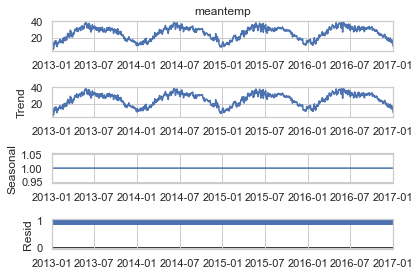

In [34]:
df_decompose_m = seasonal_decompose(df['meantemp'],period=1,model='mul')
df_decompose_m.plot()
df_decompose_m.observed 
df_decompose_m.trend
df_decompose_m.seasonal
df_decompose_m.resid

### Test for Stationarity 

#### ADF (Augmented Dickey Fuller Test) {Target Variable}

In [35]:
meantemp_adf = adfuller(df['meantemp'])

In [37]:
print('ADF Statistic: %f' % meantemp_adf[0])
print('p-value: %f' % meantemp_adf[1])
print('Critical Values:')
for key, value in meantemp_adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.021069
p-value: 0.277412
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


#### KPSS {Target Variable}

In [48]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df['meantemp'])

KPSS Statistic: 0.1948270141059301
p-value: 0.1
num lags: 24
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


* Since the pvalue for kpss is less than 0.05 , so it is not stationary.

#### ADF (Augmented Dickey Fuller Test)  

In [40]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

series = df.loc[:, 'month'].values
adf_test(series)

ADF Statistic: -3.3418698843576524
p-value: 0.013107526571904421
Critial Values:
   1%, -3.434833796443757
Critial Values:
   5%, -2.8635202989550756
Critial Values:
   10%, -2.567824293398847


The series is stationary

#### KPSS Test 

In [41]:
# KPSS test: stationarity around a trend
kpss_test(series)

KPSS Statistic: 0.4012653473860456
p-value: 0.07660976405773898
num lags: 24
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


### Model Building 

### EXPONENTIAL SMOOTHING [TRIPLE SMOOTHING]

In [46]:
df_es = ExponentialSmoothing(df['meantemp'],seasonal_periods=12,trend='add',seasonal='add').fit()

In [47]:
df_es.summary()

Dep. Variable:,meantemp,No. Observations:,1462
Model:,ExponentialSmoothing,SSE,3913.921
Optimized:,True,AIC,1471.682
Trend:,Additive,BIC,1556.282
Seasonal:,Additive,AICC,1472.156
Seasonal Periods:,12,Date:,"Tue, 22 Mar 2022"
Box-Cox:,False,Time:,23:29:24
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7818351,alpha,True
smoothing_trend,5.5855e-10,beta,True


#### RESIDUALS 

In [50]:
df_res = df_es.resid
df_res

date
2013-01-01    0.607956
2013-01-02   -2.639815
2013-01-03   -0.820713
2013-01-04    1.145942
2013-01-05   -2.350811
                ...   
2016-12-28    0.618209
2016-12-29   -1.971544
2016-12-30   -1.240493
2016-12-31    0.544274
2017-01-01   -4.864255
Length: 1462, dtype: float64

#### RMSE 

In [52]:
df_se = pow(df_res,2)
df_se.head()

date
2013-01-01    0.369611
2013-01-02    6.968621
2013-01-03    0.673570
2013-01-04    1.313183
2013-01-05    5.526312
dtype: float64

In [61]:
df_mse = (df_se.sum())/len(df_se)
print('MSE:',df_mse)

MSE: 2.677100405496404


In [57]:
from math import sqrt

In [59]:
df_rmse = sqrt(df_mse)
print('RMSE :',df_rmse)

RMSE : 1.6361847100790314


### Forecast/Predicitng and Plot - Exponential Smoothing model

In [68]:
df_predict = df_es.forecast(steps=1000)
print(df_predict)

2017-01-02    11.105060
2017-01-03    11.068226
2017-01-04    11.105745
2017-01-05    11.278194
2017-01-06    11.289659
                ...    
2019-09-24    12.228350
2019-09-25    12.272200
2019-09-26    12.235366
2019-09-27    12.272884
2019-09-28    12.445334
Freq: D, Length: 1000, dtype: float64


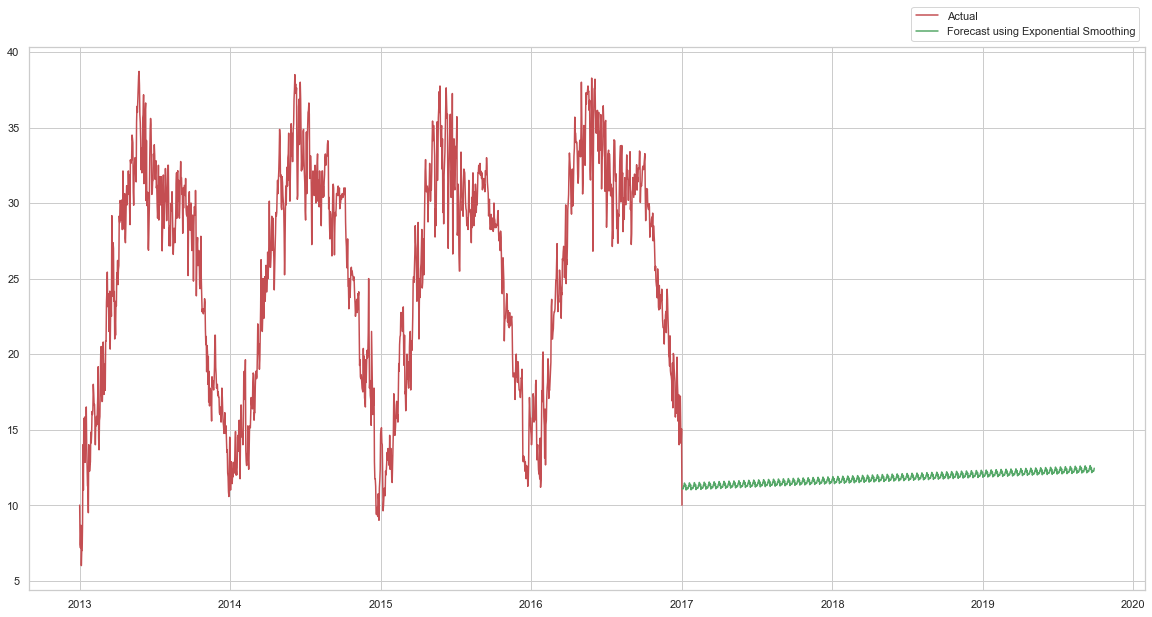

In [69]:
#Ploting the actual and forecast:
plt.figure(figsize=(20,10))
plt.plot(df['meantemp'],color='r')
plt.plot(df_predict,color='g')
plt.legend(['Actual','Forecast using Exponential Smoothing'],bbox_to_anchor=(1,1),loc=4)
plt.show()

### AUTOARIMA 

In [71]:
df_mod = auto_arima(df['meantemp'])
df_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2768.239
Date:                Tue, 22 Mar 2022   AIC                           5542.478
Time:                        23:59:41   BIC                           5558.339
Sample:                             0   HQIC                          5548.395
                               - 1462                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5728      0.046     12.494      0.000       0.483       0.663
ma.L1         -0.8028      0.036    -22.070      0.000      -0.874      -0.731
sigma2         2.5896      0.072     36.204      0.000       2.449       2.730
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               255.47
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.46
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### RESIDUALS

In [73]:
df_mod_res = df_mod.resid()
df_mod_res

array([10.        , -2.59999521, -0.67897612, ..., -1.5289966 ,
        0.38457328, -5.29228886])

#### RMSE 

In [76]:
df_mod_se = pow(df_mod_res,2)

In [79]:
df_mod_mse = (df_mod_se.sum()/len(df_mod_se))
print('MSE:',df_mod_mse)

MSE: 2.656778970705844


In [80]:
df_mod_rmse = sqrt(df_mod_mse)
print('RMSE:',df_mod_rmse)

RMSE: 1.6299628740268424


#### ACF & PACF - RESIDUAL 

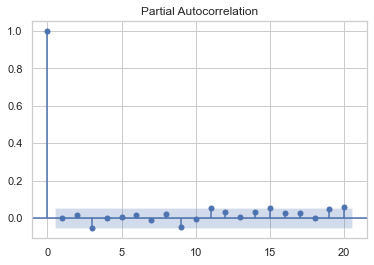

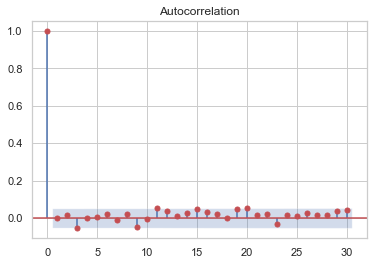

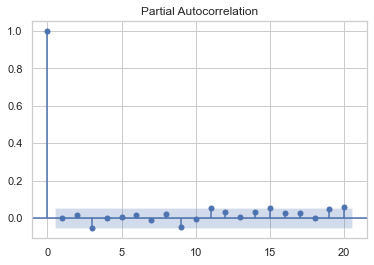

In [86]:
plot_acf(df_mod_res,color='r',lags=30) 
plot_pacf(df_mod_res,lags=20)

### Forecast/Predicitng and Plot - Auto Arima model 

In [88]:
df_mod_pred = df_mod.predict(n_periods=100)

In [94]:
df_mod_pred = pd.DataFrame(df_mod_pred,index=pd.date_range(start='2013-01-01',periods=100,freq='MS'))

In [90]:
df_mod_pred

,0
2013-01-01,11.354415
2013-02-01,12.130205
2013-03-01,12.574566
2013-04-01,12.829089
2013-05-01,12.974876
...,...
2020-12-01,13.170340
2021-01-01,13.170340
2021-02-01,13.170340
2021-03-01,13.170340


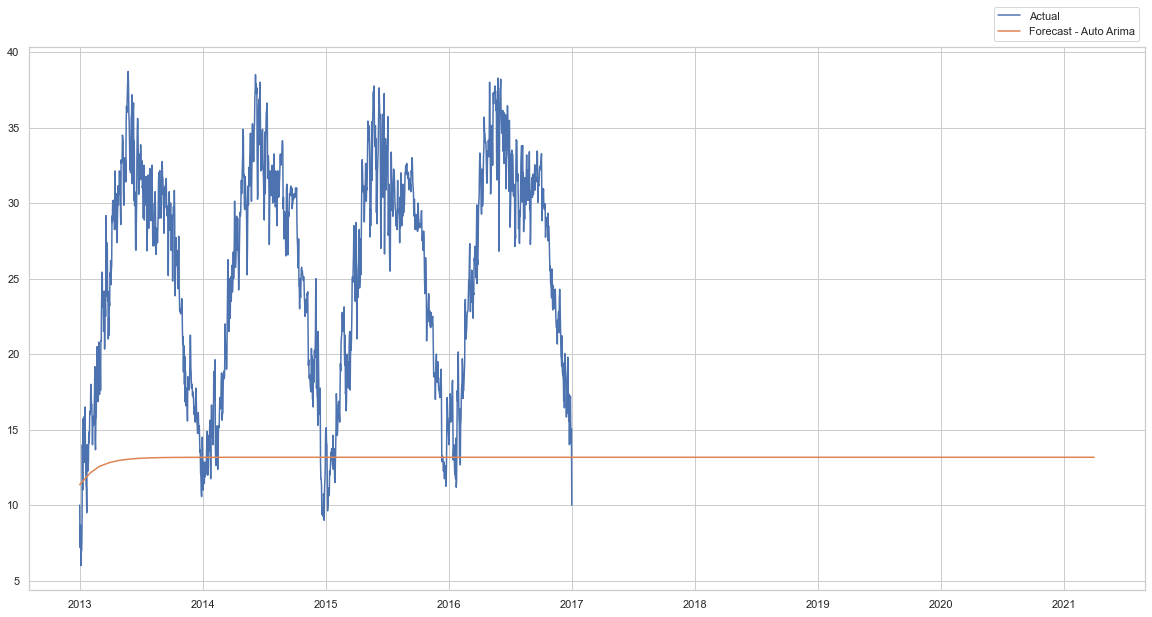

In [95]:
plt.figure(figsize=(20,10))
plt.plot(df['meantemp'])
plt.plot(df_mod_pred)
plt.legend(['Actual','Forecast - Auto Arima'],bbox_to_anchor=(1,1),loc=4)
plt.show()

#### Hence, we can conclude that both the models give accurate result as the RMSE value of both is near about same. 

# 